In [1]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.documents import Document
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_redis import RedisVectorStore
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import (
    tools_condition,  # this is the checker for the if you got a tool back
)
from langgraph.prebuilt import ToolNode

In [22]:
SYS_MSG = SystemMessage(
    content="You are an oregon trail playing AI agent. Use the tools available to answer the questions provided. Important: ff options are provided in the question replay only with the single character A, B, C, or D and no additional text."
)


In [ ]:
doc = Document(
    page_content="the northern trail, of the blue mountains, was destroyed by a flood and is no longer safe to traverse. It is recommended to take the southern trail although it is longer."
)

vectorstore = RedisVectorStore.from_documents(
    [doc],
    OpenAIEmbeddings(),
    redis_url="redis://localhost:6379/0",
    index_name="oregon_trail",
)

retriever_tool = create_retriever_tool(
    vectorstore.as_retriever(),
    "retrieve_trail_tips",
    "Search and return information that is helpful for answering questions about what to do next on the Oregon Trail",
)

tools = [retriever_tool]

15:17:17 redisvl.index.index INFO   Index already exists, not overwriting.


In [29]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


In [ ]:
def reasoner(state: MessagesState):
    print(state["messages"])
    if state['messages'][-1].name == "retrieve_blog_posts":
        prompt = {"messages": [llm_with_tools.invoke([SYS_MSG] + f"consider context: {state['messages'][-1].content}")]}
    else:
        prompt = {"messages": [llm_with_tools.invoke([SYS_MSG] + state['messages'])]}
    return prompt

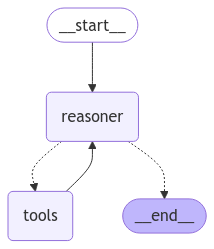

In [39]:
from IPython.display import Image, display

builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))  # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [40]:
from langchain_core.messages import HumanMessage

def format_question(q):
    question = q["question"]
    options = q.get("options", "")
    if options:
        formatted = f"{question}, options: {' '.join(options)}"
    else:
        formatted = question
    
    print(formatted)
    return [HumanMessage(content=formatted)]

In [41]:
import json

with open("questions.json") as f:
    questions = json.load(f)

res = graph.invoke({"messages": format_question(questions[0])})

You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing
[HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={}, id='45fecc11-4f31-4fba-affb-daabf3f8960f')]
[HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={},

In [45]:
res['messages'][-2].name

'retrieve_blog_posts'

In [36]:
res

{'messages': [HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={}, id='a4bd2b6e-ab9d-4dfa-893c-885fc88904ae'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rupXM8QHAx9NiRmSckSMj69q', 'function': {'arguments': '{"query": "Oregon Trail Blue Mountains northern trail vs southern trail"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}, {'id': 'call_DR8s2g9XCdfRXf3bDWwH8qKF', 'function': {'arguments': '{"query": "Oregon Trail strategies dense forest"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}, {'id': 'call_NRTFiZ5mPcXT7JFDErjwvpVF', 'function': {'arguments': '{"query": "Oregon Trail fishing in dense forest"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'r